## Import necessary packages

In [2]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings 
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import luminol
from luminol.anomaly_detector import AnomalyDetector
%matplotlib inline

## ARIMA - https://www.gov.uk - visits in National Gallery of London

In [3]:
museum = pd.read_csv('National_Gallery.csv', parse_dates=True, index_col='month')

In [4]:
museum.head()

,visitors
month,
2005-01-01,402000
2005-02-01,342000
2005-03-01,507000
2005-04-01,455000
2005-05-01,417000


In [5]:
museum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2005-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   visitors  157 non-null    int64
dtypes: int64(1)
memory usage: 2.5 KB


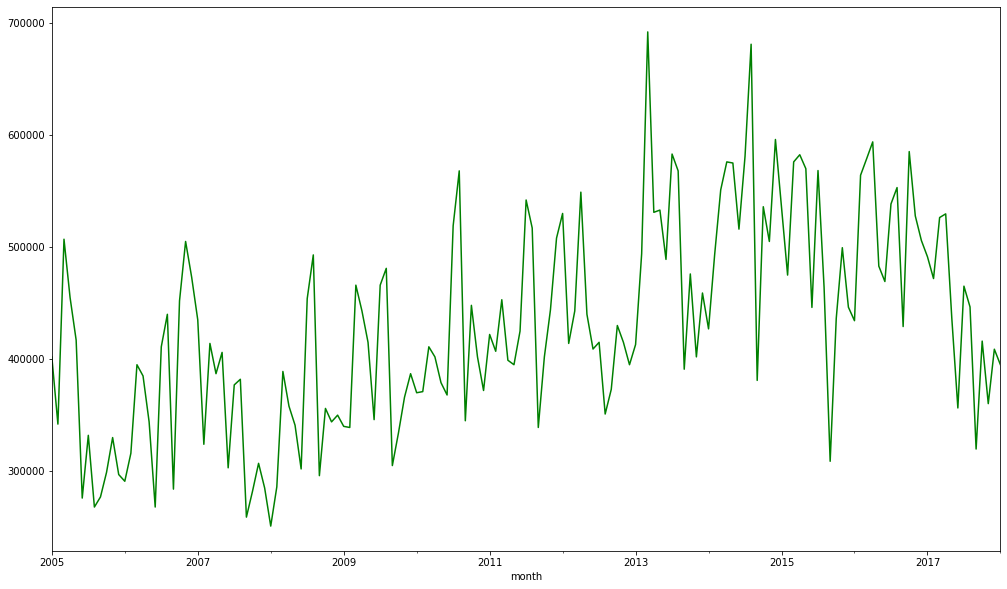

In [6]:
plt.figure(figsize = (17,10))
museum.visitors.plot(color = 'g')
plt.ylabel = ('Visitor number')
plt.show()

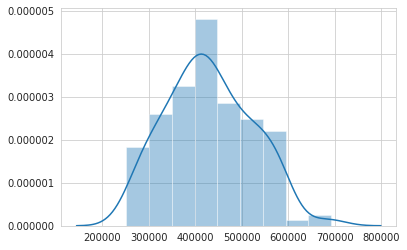

In [7]:
sns.set_style('whitegrid')
sns.distplot(museum)

In [8]:
print ('Standard deviation = %f'%np.std(museum))
print ('Mean = %f'%np.mean(museum))
print ('CoVariation = %f' % (np.std(museum)/np.mean(museum)))

Standard deviation = 92054.895367
Mean = 429628.414013
CoVariation = 0.214266


## Stationary check and STL-decomposition

Dickey Fuller 0.402642456753068


<Figure size 864x720 with 0 Axes>

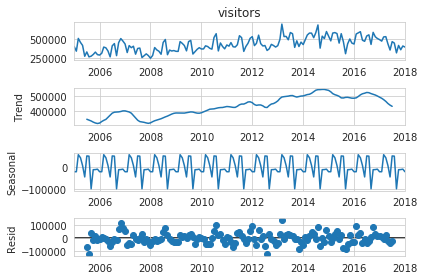

In [9]:
plt.figure(figsize = (12,10))
result = seasonal_decompose(museum.visitors)
result.plot()
print ('Dickey Fuller {}'.format(sm.tsa.stattools.adfuller(museum.visitors)[1]))

## Dispersion equalization - Box–Cox transformation

Optimal param BOX-COX 0.40840206141368074
Dickey Fuller 0.3757461273343674


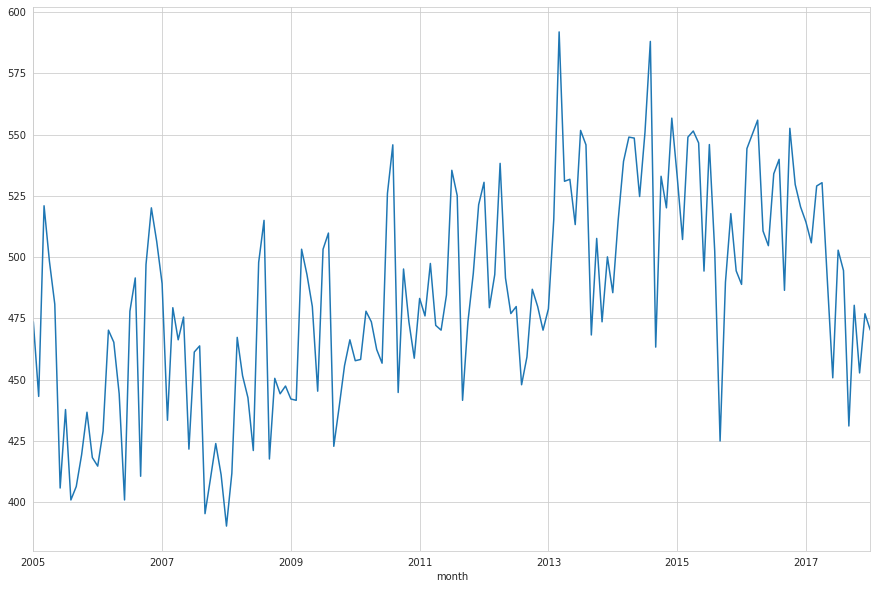

In [10]:
museum['visit_box'], lmbda = stats.boxcox(museum.visitors)
plt.figure(figsize = (15,10))
museum.visit_box.plot()
print ('Optimal param BOX-COX {}'.format(lmbda))
print ('Dickey Fuller {}'.format(sm.tsa.stattools.adfuller(museum.visit_box)[1]))

Dickey Fuller 0.001349580690877623


<Figure size 1080x720 with 0 Axes>

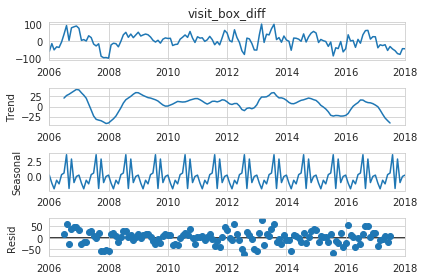

In [11]:
museum['visit_box_diff'] = museum.visit_box - museum.visit_box.shift(12)
plt.figure(figsize = (15,10))
result_diff = seasonal_decompose(museum.visit_box_diff[12:]).plot()
print ('Dickey Fuller {}'.format(sm.tsa.stattools.adfuller(museum.visit_box_diff[12:])[1]))

Dickey Fuller 4.075848181692197e-07


<Figure size 1080x720 with 0 Axes>

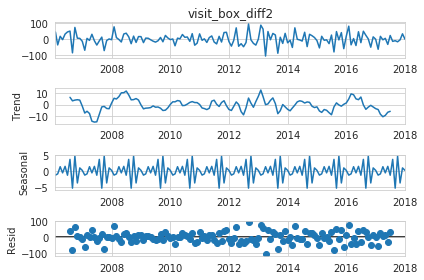

In [12]:
museum['visit_box_diff2'] = museum.visit_box_diff - museum.visit_box_diff.shift(1)
plt.figure(figsize = (15,10))
result_diff = seasonal_decompose(museum.visit_box_diff2[13:]).plot()
print ('Dickey Fuller {}'.format(sm.tsa.stattools.adfuller(museum.visit_box_diff2[13:])[1]))

## Model params
## ACF & PACF

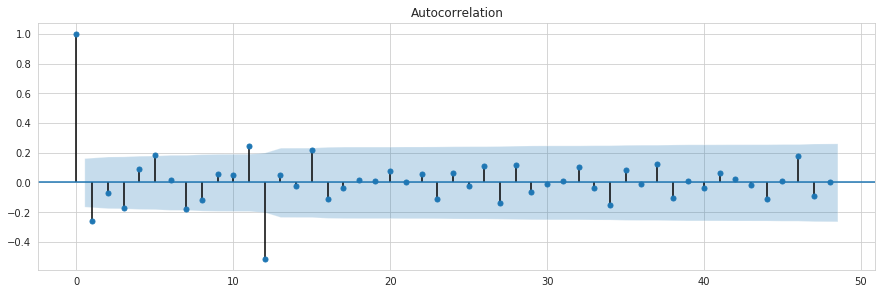

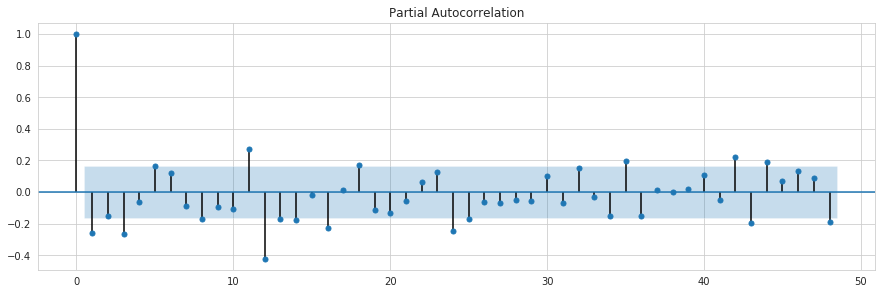

In [13]:
plt.figure(figsize = (15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(museum.visit_box_diff2[13:].values.squeeze(), lags = 48, ax = ax)
plt.show()
plt.figure(figsize = (15,10))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(museum.visit_box_diff2[13:].values.squeeze(), lags = 48, ax = ax)
plt.show()

## First params

In [14]:
ps = range (0,5)
d = 1
qs = range (0,3)
Ps = range (0,2)
D = 1
Qs = range(0,2)

In [15]:
parameters = product (ps,qs, Ps,Qs)
parameters_list = list(parameters)
parameters_list
len (parameters_list)

60

In [16]:
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(museum.visit_box, order = (param[0], d, param[1]),
                                         seasonal_order = (param[2], D, param[3], 12)).fit(disp = -1)
    except:
        print ('Wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings ('default')

In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending = [True]).head())

      parameters          aic
35  (2, 2, 1, 1)  1346.543005
33  (2, 2, 0, 1)  1347.364411
17  (1, 1, 0, 1)  1348.213903
19  (1, 1, 1, 1)  1348.372844
29  (2, 1, 0, 1)  1349.340420


In [18]:
print (best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            visit_box   No. Observations:                  157
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -666.272
Date:                              Sat, 23 May 2020   AIC                           1346.543
Time:                                      08:12:56   BIC                           1367.332
Sample:                                  01-01-2005   HQIC                          1354.990
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4143      0.378     -1.096      0.273      -1.155       0.327
ar.L2          0.58

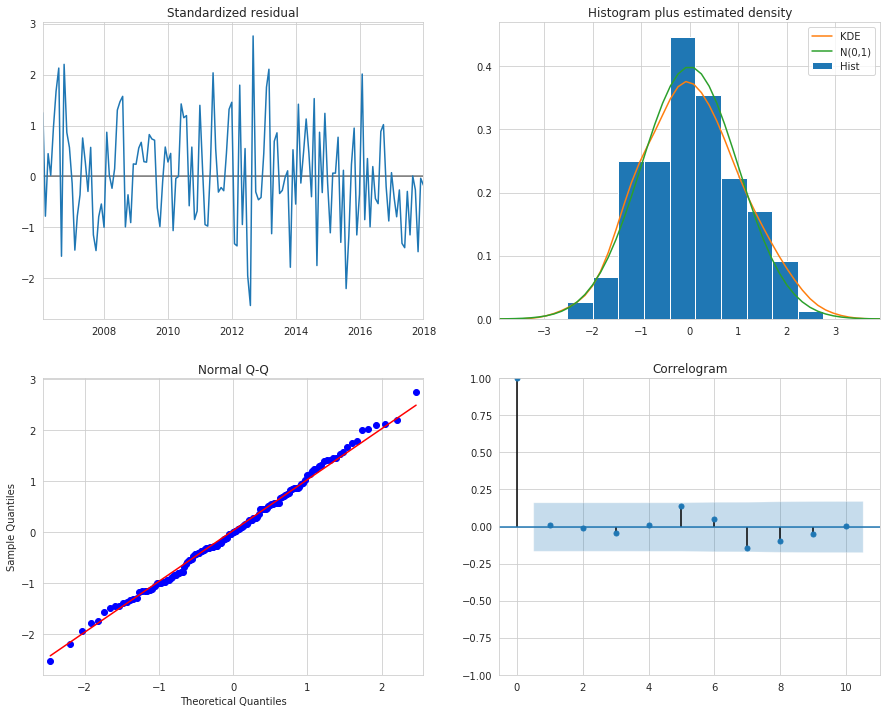

In [19]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

## Residuals analysis

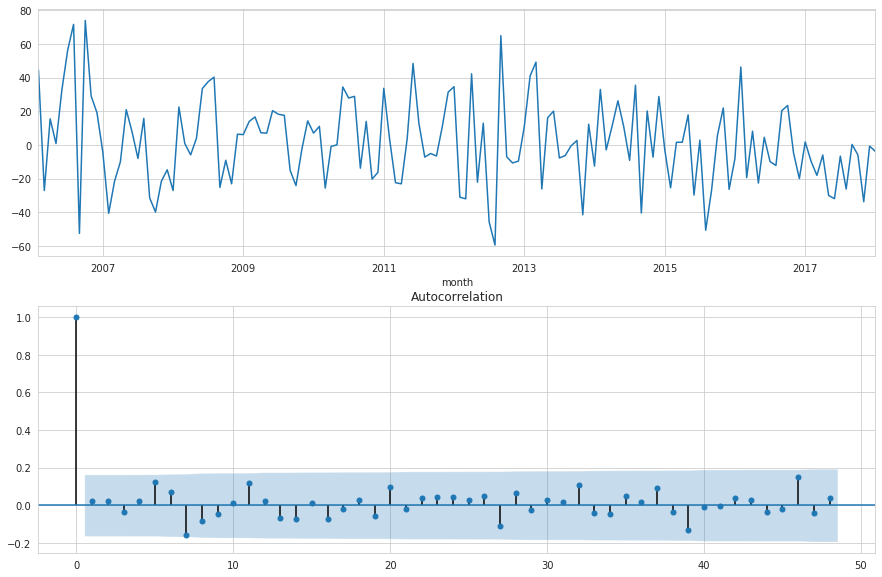

Student criteria: p = 0.5270278518590319
Dickey Fuller Test 1.1445182608798908e-21


In [20]:
plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags = 48, ax = ax)

plt.show()

print ('Student criteria: p = {}'.format (stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print ('Dickey Fuller Test {}'.format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

### Residuals are not biased (Student), stationary (Fuller), not autocorrelated (Luing Box and correlogram)

/home/sanya/anaconda3/envs/ml0/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



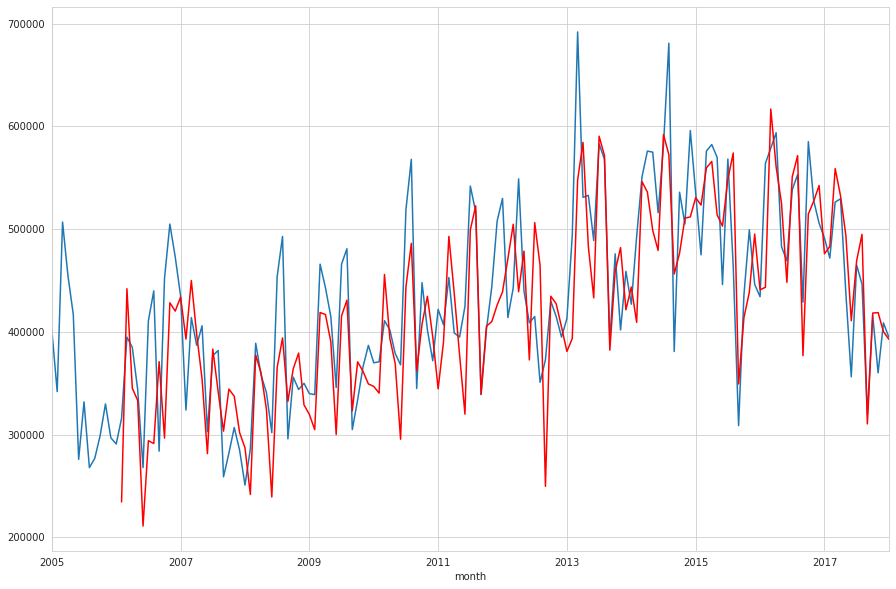

In [21]:
#invert boxcox function
def invboxcox (y, lmbda):
    if lmbda ==0:
        return (np.exp(y))
    else:
        return (np.exp(np.log(lmbda*y-1)/lmbda))

museum['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (15,10))
museum.visitors.plot()
museum.model[13:].plot(color = 'r')
plt.show()

## ARIMA forecast

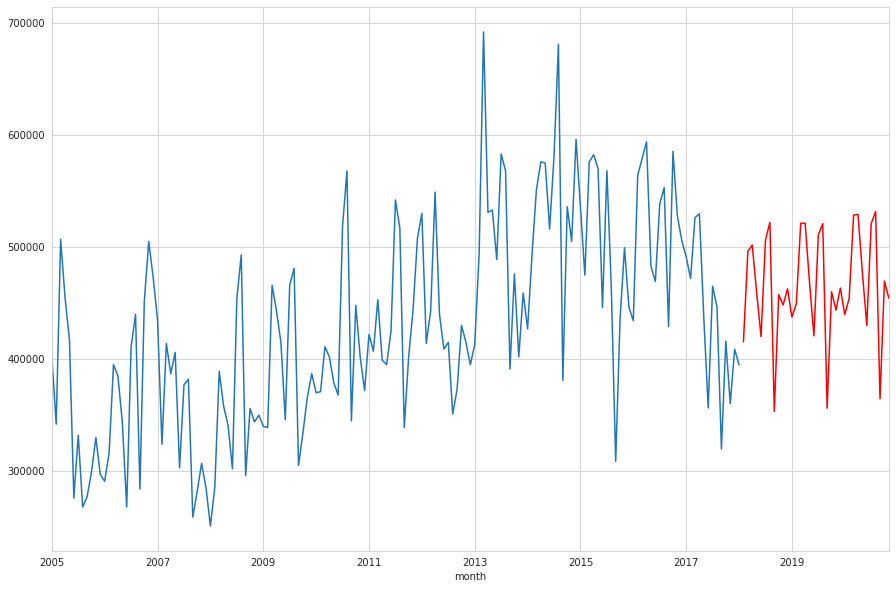

In [22]:
predict = best_model.predict(start = 157, end = 190, dynamic=True)
predict
pred1 = invboxcox(predict, lmbda)
plt.figure(figsize = (15,10))
museum.visitors.plot()
pred1.plot(color = 'r')
plt.show()

# Prophet - https://github.com/facebook/prophet

In [23]:
#Data - Office for National Statistics of UK  / https://www.ons.gov.uk/economy/nationalaccounts/uksectoraccounts/datasets/unitedkingdomeconomicaccountsflowoffunds
#Insurance corporations and pension funds; Pension schemes; Liability; £ million
df = pd.read_csv('data.csv')
df.head(5)

,date,value
0,1987-03-31,6801
1,1987-06-30,7070
2,1987-09-30,7154
3,1987-12-31,7262
4,1988-03-31,7444


In [24]:
df.dtypes

date     object
value     int64
dtype: object

In [25]:
df['date'] = pd.DatetimeIndex(df['date'])
df.dtypes

date     datetime64[ns]
value             int64
dtype: object

In [26]:
df = df.rename(columns={'date': 'ds',
                        'value': 'y'})
df.head(5)

,ds,y
0,1987-03-31,6801
1,1987-06-30,7070
2,1987-09-30,7154
3,1987-12-31,7262
4,1988-03-31,7444


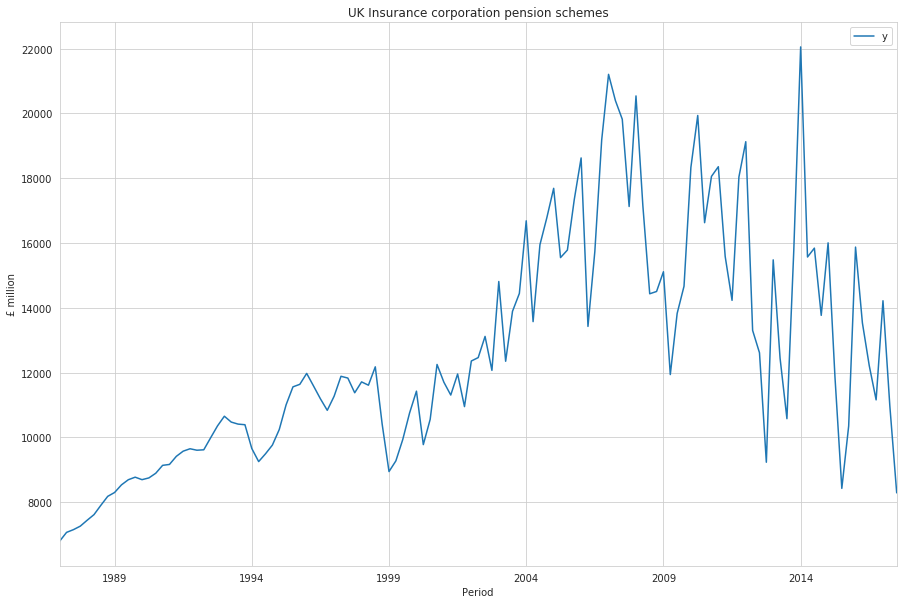

In [27]:
ax = df.set_index('ds').plot(figsize=(15, 10))
ax.set_title('UK Insurance corporation pension schemes')
ax.set_ylabel('£ million')
ax.set_xlabel('Period')
plt.show()

### Set the uncertainty interval to 95% (the Prophet default is 80%)

In [28]:
my_model = Prophet(interval_width=0.95)

In [29]:
my_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future_dates = my_model.make_future_dataframe(periods=40, freq='Q')
future_dates.tail()

,ds
158,2026-09-30
159,2026-12-31
160,2027-03-31
161,2027-06-30
162,2027-09-30


In [31]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
158,2026-09-30,10240.141785,6174.221504,14231.828119
159,2026-12-31,10636.325024,6787.040598,14530.848114
160,2027-03-31,11732.601662,7585.128347,15684.104996
161,2027-06-30,10368.196871,6386.444139,14542.056241
162,2027-09-30,10009.404305,6115.865279,13939.283592


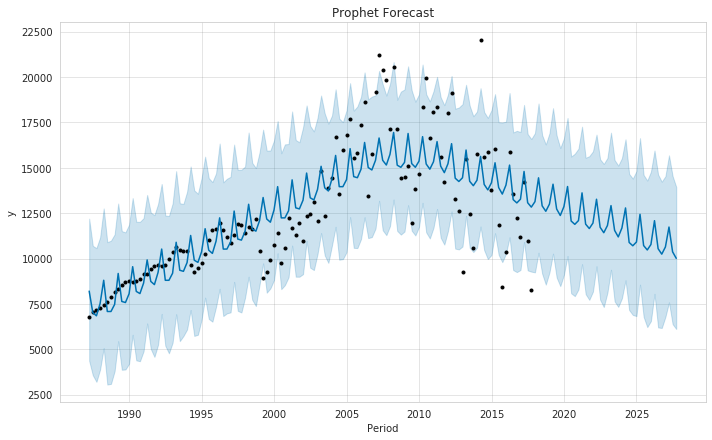

In [32]:
my_model.plot(forecast, uncertainty=True)
plt.xlabel('Period')
plt.title('Prophet Forecast')
plt.show()

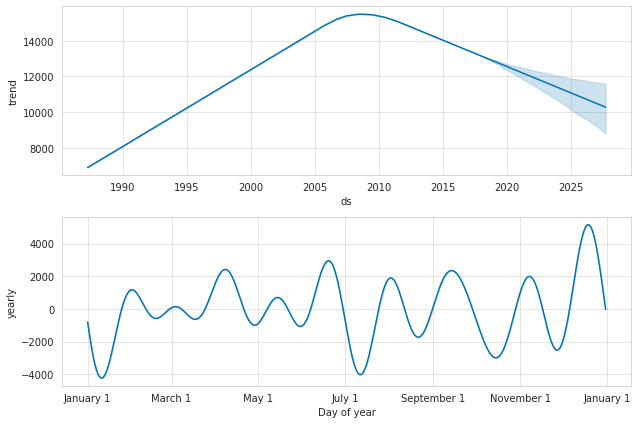

In [33]:
my_model.plot_components(forecast)
plt.show()

# Anomaly Detection - Seasonal decomposition

In [36]:
df = pd.read_csv('data.csv')
df.set_index(['date'], inplace=True)
ts = df.copy()
ts.index.name=None

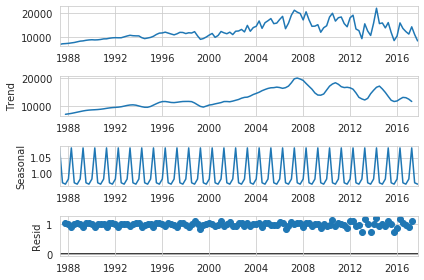

In [57]:
series = pd.read_csv('data.csv', index_col=0, parse_dates=True, header = 0)
result = seasonal_decompose(series, model = 'multiplicative')
result.plot()
plt.show()

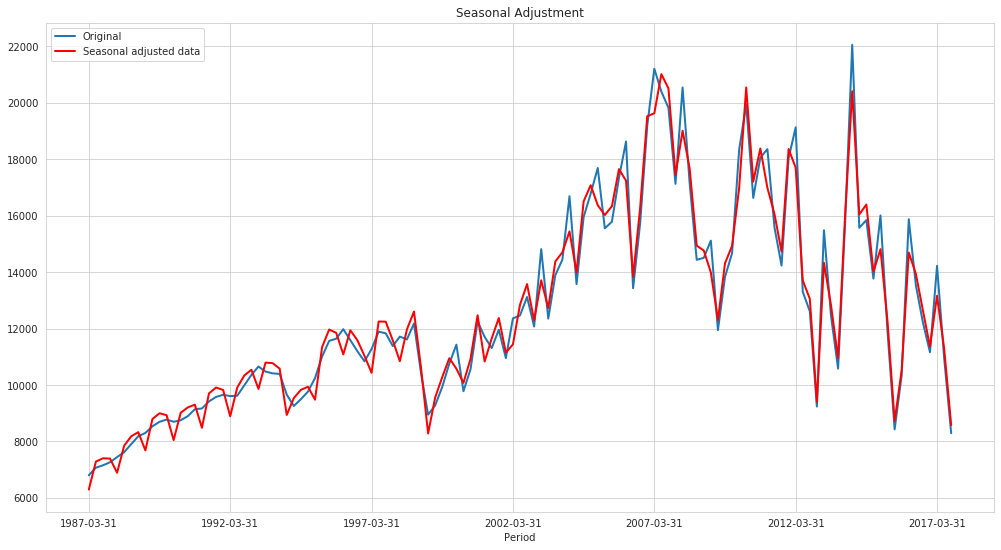

In [58]:
seas_res = result.seasonal
seas_adj = ts['value'] / seas_res
ts['seas_adj_data'] = seas_adj
ts['seas_res'] = seas_res
plt.figure(figsize=(17, 9))
ts['value'].plot(linewidth = 2,label = 'Original')
ts['seas_adj_data'].plot(color = 'red', linewidth = 2, label = "Seasonal adjusted data")
plt.xlabel('Period')
plt.title('Seasonal Adjustment')
plt.legend()

In [59]:
ts.head()

,value,seas_adj_data,seas_res
1987-03-31,6801,6293.915399,1.080567
1987-06-30,7070,7284.193502,0.970595
1987-09-30,7154,7402.903626,0.966378
1987-12-31,7262,7391.647679,0.982460
1988-03-31,7444,6888.973126,1.080567


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Quarters')

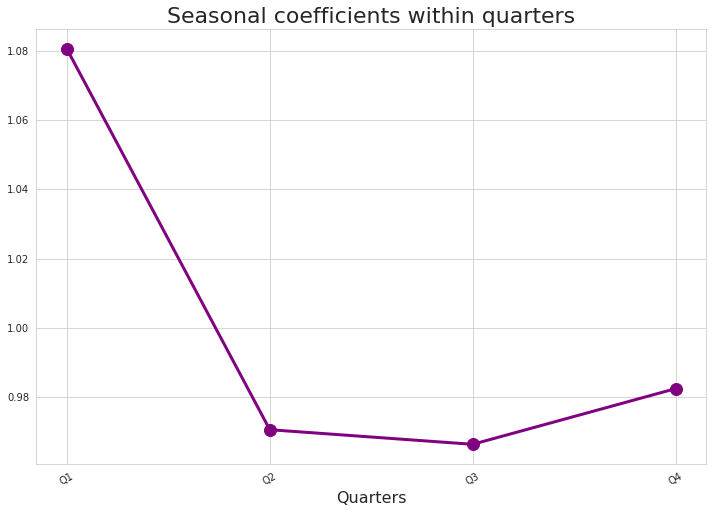

In [60]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.plot(ts['seas_res'].drop_duplicates(), linewidth = 3, color = 'purple', marker = 'o', markersize = 12)
labels = ax.set_xticklabels(['Q1','Q2','Q3','Q4'],rotation = 30)
plt.title('Seasonal coefficients within quarters', fontsize = 22)
plt.xlabel('Quarters', fontsize = 16)


# Anomaly Detection - Outliers - Luminol - https://github.com/linkedin/luminol

In [61]:
data = np.array(ts['value'])
ts_s = pd.Series(data)
ts_dict = ts_s.to_dict()
ts_dict

{0: 6801,
 1: 7070,
 2: 7154,
 3: 7262,
 4: 7444,
 5: 7618,
 6: 7906,
 7: 8182,
 8: 8301,
 9: 8536,
 10: 8695,
 11: 8774,
 12: 8697,
 13: 8751,
 14: 8895,
 15: 9139,
 16: 9167,
 17: 9417,
 18: 9577,
 19: 9651,
 20: 9606,
 21: 9619,
 22: 9990,
 23: 10356,
 24: 10655,
 25: 10475,
 26: 10412,
 27: 10393,
 28: 9659,
 29: 9255,
 30: 9496,
 31: 9764,
 32: 10243,
 33: 11008,
 34: 11562,
 35: 11640,
 36: 11977,
 37: 11588,
 38: 11194,
 39: 10837,
 40: 11273,
 41: 11888,
 42: 11833,
 43: 11379,
 44: 11715,
 45: 11613,
 46: 12180,
 47: 10414,
 48: 8947,
 49: 9277,
 50: 9933,
 51: 10757,
 52: 11429,
 53: 9779,
 54: 10558,
 55: 12253,
 56: 11704,
 57: 11309,
 58: 11958,
 59: 10952,
 60: 12360,
 61: 12465,
 62: 13119,
 63: 12071,
 64: 14814,
 65: 12352,
 66: 13894,
 67: 14445,
 68: 16687,
 69: 13575,
 70: 15950,
 71: 16779,
 72: 17690,
 73: 15552,
 74: 15784,
 75: 17339,
 76: 18628,
 77: 13428,
 78: 15739,
 79: 19182,
 80: 21208,
 81: 20398,
 82: 19822,
 83: 17129,
 84: 20542,
 85: 17156,
 86: 1443

In [62]:
detector = luminol.anomaly_detector.AnomalyDetector(ts_dict)
anomalies = detector.get_anomalies()

/home/sanya/anaconda3/envs/ml0/lib/python3.8/site-packages/luminol/modules/time_series.py:337: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



In [63]:
#Scoring
score = detector.get_all_scores()
score_dict = {}
for item, value in score.iteritems():
    score_dict[item] = value
score_dict

{0: 0.0,
 1: 0.06092879736157683,
 2: 0.11648906264590769,
 3: 0.09969411926480048,
 4: 0.10416514037554193,
 5: 0.12274330464584,
 6: 0.163426962081483,
 7: 0.19325587476479666,
 8: 0.18155833135840851,
 9: 0.198474424863569,
 10: 0.1947932156547612,
 11: 0.17372815985304518,
 12: 0.12154194276406635,
 13: 0.1113290178315153,
 14: 0.12018785030612916,
 15: 0.15141654997064571,
 16: 0.13412808734016038,
 17: 0.15860549310126312,
 18: 0.16312457135035002,
 19: 0.1472607388823495,
 20: 0.10761604136137747,
 21: 0.10027797963424573,
 22: 0.20717670032176322,
 23: 0.2176681589788953,
 24: 0.23341089856895328,
 25: 0.14595851987715536,
 26: 0.12398278532289238,
 27: 0.11361770510401661,
 28: 0.2971369526583799,
 29: 0.1747835590628038,
 30: 0.08524008084080097,
 31: 0.010563181805510892,
 32: 0.14469033555129107,
 33: 0.34036691885350934,
 34: 0.32970170638771834,
 35: 0.3237678412824959,
 36: 0.3014736335982285,
 37: 0.15306997686500118,
 38: 0.03321454595125223,
 39: 0.054289257878711875,

In [64]:
from operator import itemgetter
score_dict_sorted = sorted(score_dict.items(), key=itemgetter(1))

In [65]:
#Results
top_three_anom = score_dict_sorted[-3:]
for anom in top_three_anom:
    print ('Position = {}, Value = {}'.format(anom[0], anom[1]))

Position = 77, Value = 1.9285394682291854
Position = 101, Value = 2.0662272625150586
Position = 108, Value = 3.203801421063209


# Anomaly Detection - Outlier Detector - 'Sigma Rule'

In [66]:
df = pd.read_csv('data.csv')
df.set_index(['date'], inplace=True)
ts = df.copy()
ts.index.name=None

## 1.Two sigmas rule = probability 0,9544

In [67]:
def reject_outliers(data):
    mean = np.mean(data.value)
    std = np.std(data.value)
    data_filtered = data[(data.value > mean-2*std) & (data.value < mean+2*std)]
    data_anomaly = data[(data.value < mean-2*std) | (data.value > mean+2*std)] 
    if data_anomaly.empty:
        print ("Anomalies were not detected")
        
    else:
        print ("Anomalies were detected")
    return data_filtered, data_anomaly

anomaly_cleared, anomaly_list = reject_outliers(ts)
anomaly_list

Anomalies were detected


,value
2007-03-31,21208
2007-06-30,20398
2007-09-30,19822
2008-03-31,20542
2010-06-30,19939
2014-03-31,22055


## 2.Three sigmas rule = probability 0,9973

In [68]:
def reject_outliers(data):
    mean = np.mean(data.value)
    std = np.std(data.value)
    data_filtered = data[(data.value > mean-3*std) & (data.value < mean+3*std)]
    data_anomaly = data[(data.value < mean-3*std) | (data.value > mean+3*std)] 
    if data_anomaly.empty:
        print ("Anomalies were not detected")
    else:
        print ("Anomalies were detected")
    return data_filtered, data_anomaly

anomaly_cleared, anomaly_list = reject_outliers(ts)
anomaly_list

Anomalies were not detected


,value


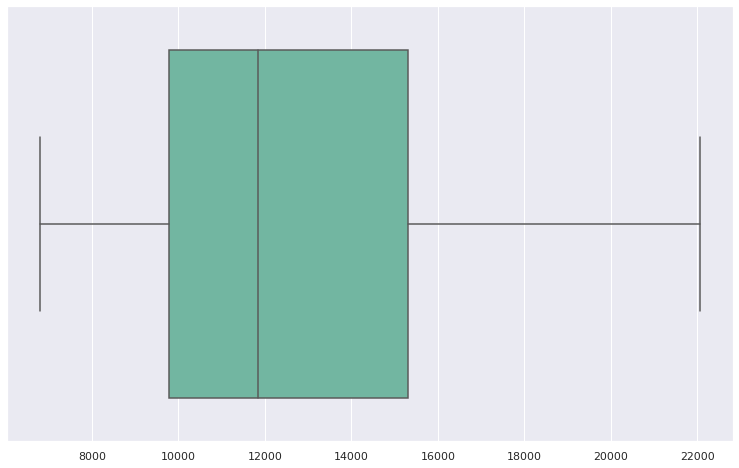

In [69]:
#Boxplot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(13,8)})
sns.boxplot(ts, palette='Set2')

# Outlier Adjustment - Winsorizing / https://en.wikipedia.org/wiki/Winsorizing

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<ipython-input-70-e4ee766a1f45>:13: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>



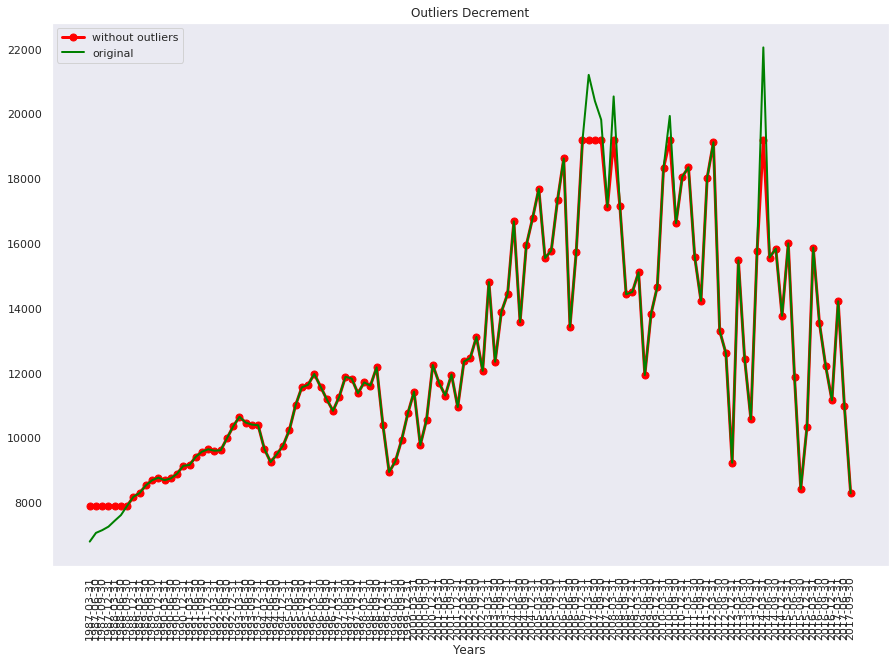

In [70]:
#1. 90% winsorization
a = ts['value']
res = np.array(stats.mstats.winsorize(a, limits=0.05))
plt.figure(figsize = (15,10))
plt.legend(loc=2)
plt.plot(res, color = 'red', marker = 'o', markersize=7, linewidth = 3, label = 'without outliers')
plt.plot(a, color = 'green', label = 'original', linewidth = 2)
plt.legend(loc=2)
plt.title('Outliers Decrement')
plt.xlabel('Years')
plt.grid()
plt.xticks(rotation=90)
plt.locator_params(nbins=100, axis = 'x')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<ipython-input-71-0303379e1d42>:13: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>



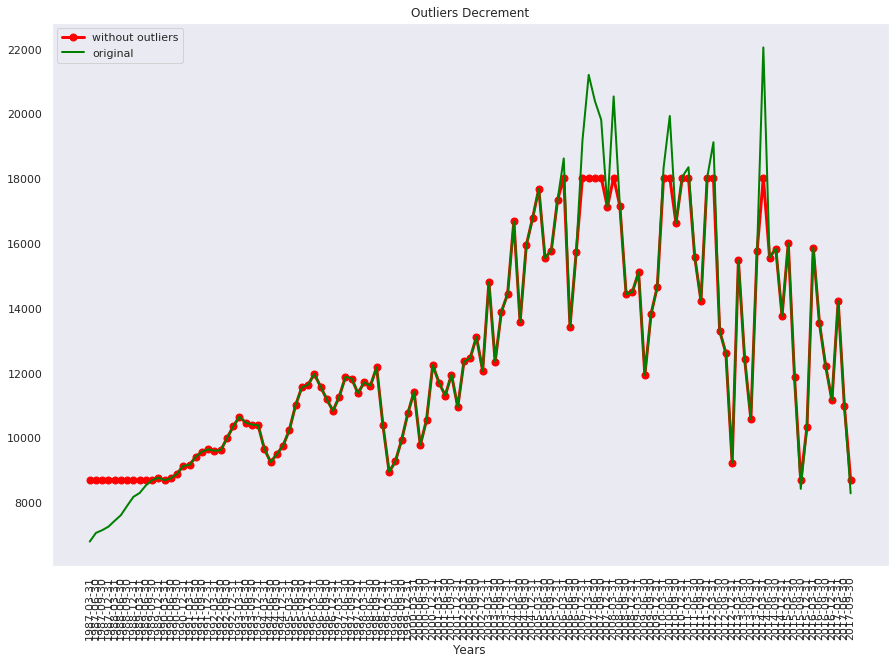

In [71]:
#2. 80% winsorization
a = ts['value']
res = np.array(stats.mstats.winsorize(a, limits=0.1))
plt.figure(figsize = (15,10))
plt.legend(loc=2)
plt.plot(res, color = 'red', marker = 'o', markersize=7,linewidth = 3, label = 'without outliers')
plt.plot(a, color = 'green', label = 'original', linewidth = 2)
plt.legend(loc=2)
plt.title('Outliers Decrement')
plt.xlabel('Years')
plt.grid()
plt.xticks(rotation=90)
plt.locator_params(nbins=100, axis = 'x')

# Bivariate Outliers - EllipticEnvelope model

## Data - World Happiness Report - https://www.kaggle.com/unsdsn/world-happiness/data

In [72]:
from sklearn.covariance import EllipticEnvelope

df1 = pd.read_csv("2017.csv")
country = df1["Country"]
params = ["Happiness.Score", "Economy..GDP.per.Capita."]
params_data = np.array([df1[params[0]], df1[params[1]]]).T
df1.head()

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [73]:
ee = EllipticEnvelope()
ee.fit(params_data)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
                 store_precision=True, support_fraction=None)

In [74]:
biv_outliers_mask = ee.predict(params_data) == -1
biv_outliers_data = params_data[biv_outliers_mask]
biv_outliers_name = country[biv_outliers_mask]

In [75]:
xx, yy = np.meshgrid(np.linspace(params_data[:, 0].min(), params_data[:, 0].max(), 100),
                     np.linspace(params_data[:, 1].min(), params_data[:, 1].max(), 100))
zz = ee.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

Text(0, 0.5, 'Economy..GDP.per.Capita.')

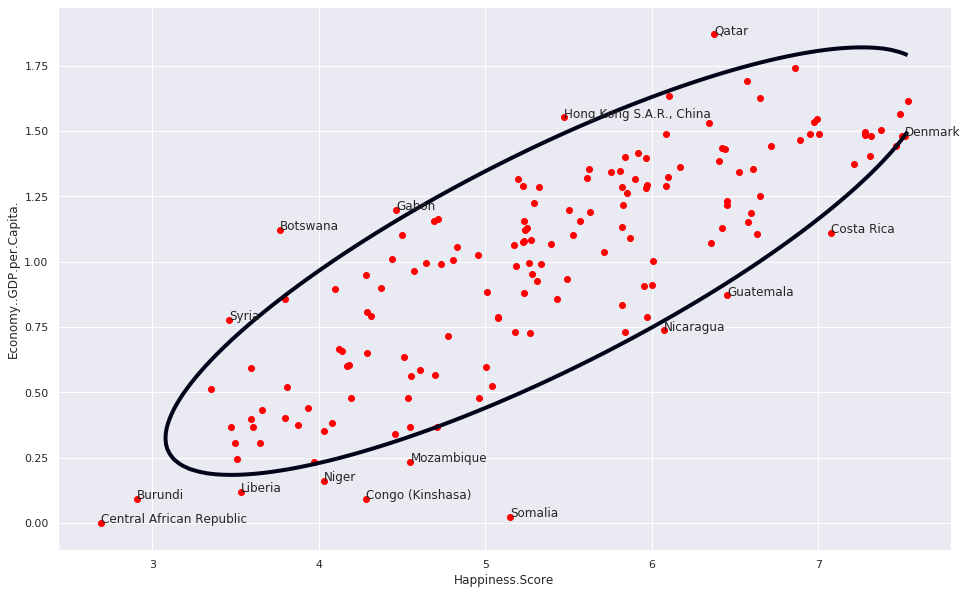

In [78]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1, 1, 1)
for name, xy in zip(biv_outliers_name, biv_outliers_data):
    ax.text(xy[0], xy[1], name)
ax.contour(xx, yy, zz, levels=[0], linewidths=4)
ax.scatter(params_data[:, 0], params_data[:, 1], color='red')
ax.set_xlabel(params[0])
ax.set_ylabel(params[1])

# Thank you!